Epoch 1/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6891
Epoch 2/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6109
Epoch 3/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6058
Epoch 4/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.6041
Epoch 5/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.6040
Epoch 6/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6044
Epoch 7/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6037
Epoch 8/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.6040
Epoch 9/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6041
Epoch 10/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.6037
Epoch 11/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6033
Epoch 12/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.6038
Epoch 13/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.6032
Epoch 14/50
16028/16028 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - 

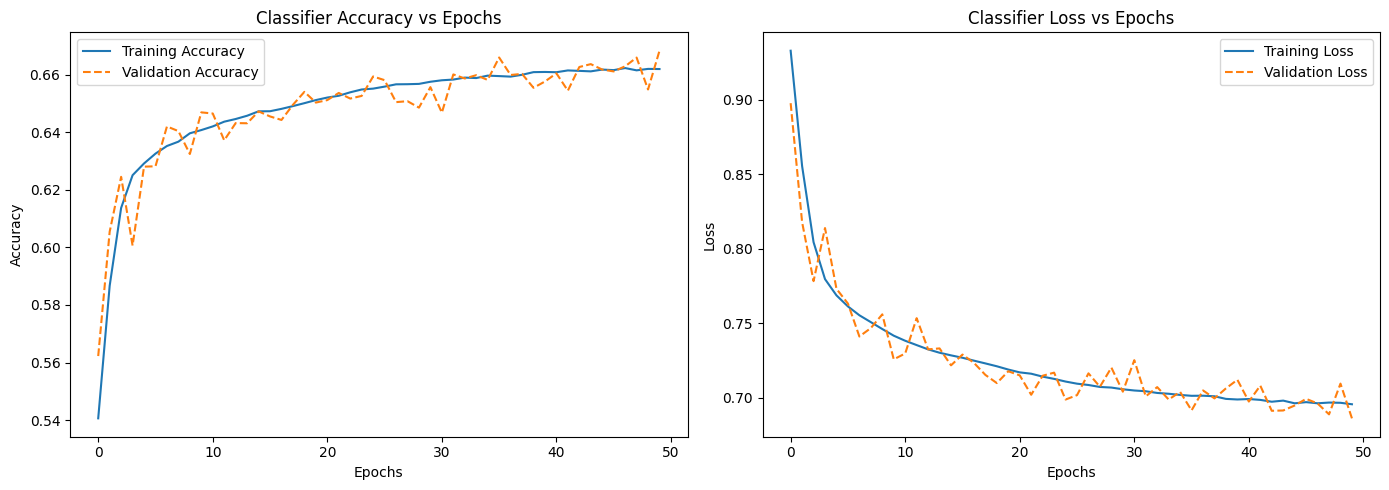

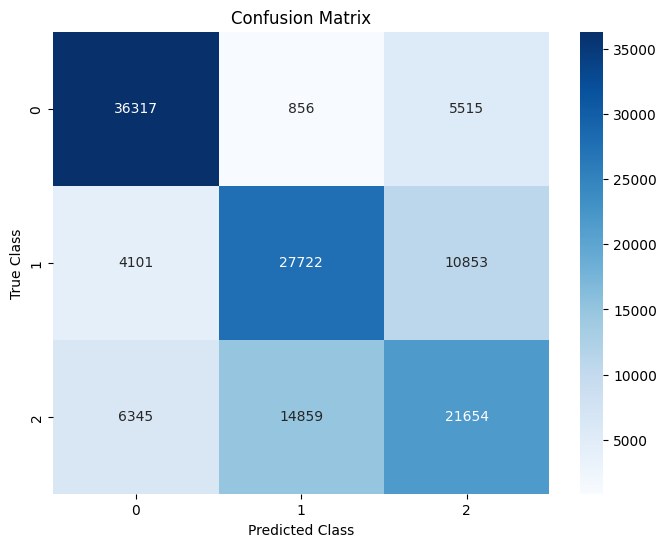

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/content/drive/MyDrive/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop('Diabetes_012', axis=1).values
y = data['Diabetes_012'].values

# Check for class imbalance and correct it using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define a more complex Autoencoder model to potentially improve accuracy
input_dim = X_train.shape[1]
encoding_dim = 32  # Increased encoding dimension for better feature extraction

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)  # Adding another encoding layer
decoded = layers.Dense(16, activation='relu')(encoded)  # Adding another decoding layer
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)

# Compile the model with different optimizer settings
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Convert training data into TensorFlow dataset for better handling
train_auto_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).batch(32).shuffle(buffer_size=1024)

# Train the Autoencoder with more epochs for better convergence
history_autoencoder = autoencoder.fit(train_auto_dataset, epochs=50, verbose=1)

# Extract the encoder model for classification
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Build a classifier using the encoded features
encoded_input = layers.Input(shape=(16,))
classifier_layer = layers.Dense(32, activation='relu')(encoded_input)
classifier_layer = layers.Dense(16, activation='relu')(classifier_layer)
classifier_layer = layers.Dense(3, activation='softmax')(classifier_layer)
classifier = models.Model(inputs=encoded_input, outputs=classifier_layer)

# Compile the classifier with a different learning rate
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier on the encoded data using a TensorFlow dataset
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).batch(32)

# Train the classifier with more epochs and using tf.data.Dataset
history_classifier = classifier.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=1)

# Evaluate the model
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate and display accuracy
train_accuracy = accuracy_score(y_train, np.argmax(classifier.predict(X_train_encoded), axis=1))
test_accuracy = accuracy_score(y_test, y_pred_classes)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

# Plotting the accuracy and loss curves
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy for classifier
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Classifier Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss for classifier
plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Classifier Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
